In [1]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [8]:
import pandas as pd

url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)
print(df.head())


      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [9]:
# Shape and column names
print(df.shape)          # (rows, cols)
print(df.columns.tolist())

# Data types & non-null counts
print(df.info())

# Basic statistics
print(df.describe().T)

# Missing values check
print(df.isna().sum())


(506, 14)
['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None
         count        mean         std        min         25%        50%  \
crim     506.0    3.613524    8.601545

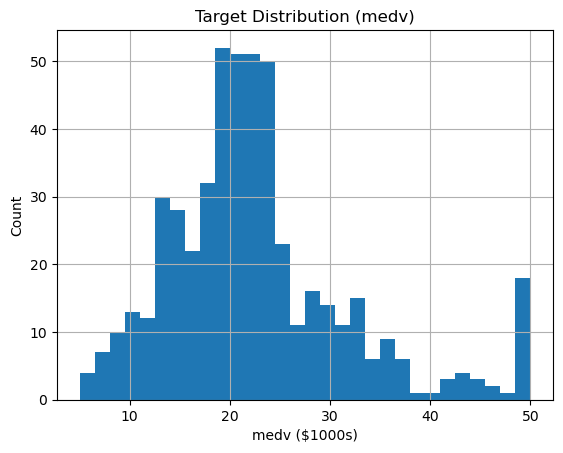

In [26]:
target = "medv"
features = [c for c in df.columns if c != target]

# Peek at target distribution
import matplotlib.pyplot as plt

plt.figure()
df[target].hist(bins=30)
plt.xlabel("medv ($1000s)")
plt.ylabel("Count")
plt.title("Target Distribution (medv)")
plt.savefig('target_distribution.png')
plt.show()


lstat      0.737663
rm         0.695360
ptratio    0.507787
indus      0.483725
tax        0.468536
nox        0.427321
crim       0.388305
rad        0.381626
age        0.376955
zn         0.360445
Name: medv, dtype: float64


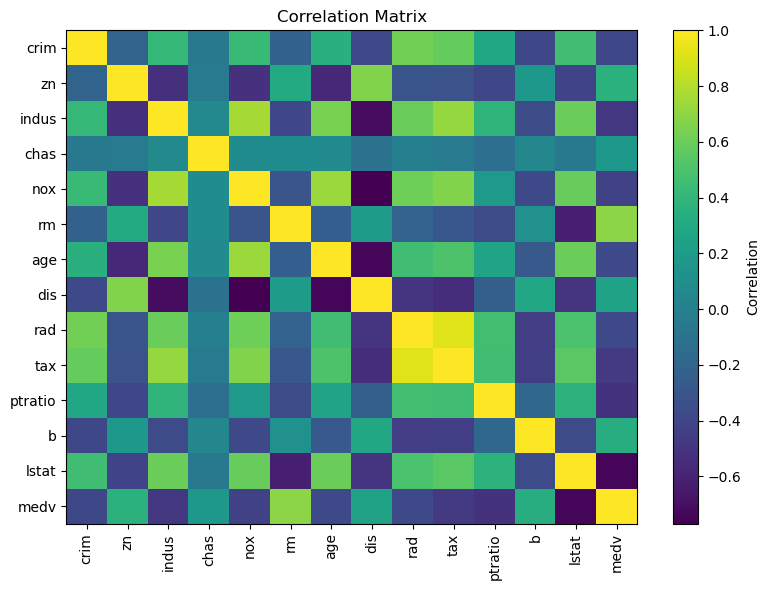

In [27]:
import numpy as np

corr = df.corr(numeric_only=True)
# Top 10 absolute correlations with target (excluding self)
top_corr = corr[target].drop(target).abs().sort_values(ascending=False).head(10)
print(top_corr)

# Visual peek at the whole correlation matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


In [12]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((404, 13), (102, 13))

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

mae_lr  = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr   = r2_score(y_test, pred_lr)

print(f"Linear Regression -> MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.3f}")


Linear Regression -> MAE: 3.19, RMSE: 4.93, R²: 0.669


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf   = r2_score(y_test, pred_rf)

print(f"Random Forest     -> MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")


Random Forest     -> MAE: 2.09, RMSE: 2.98, R²: 0.879


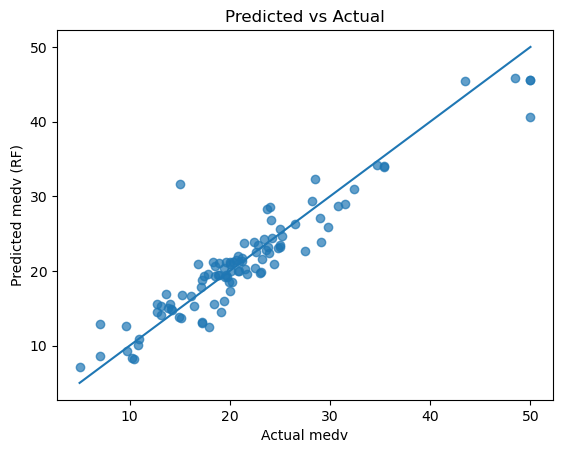

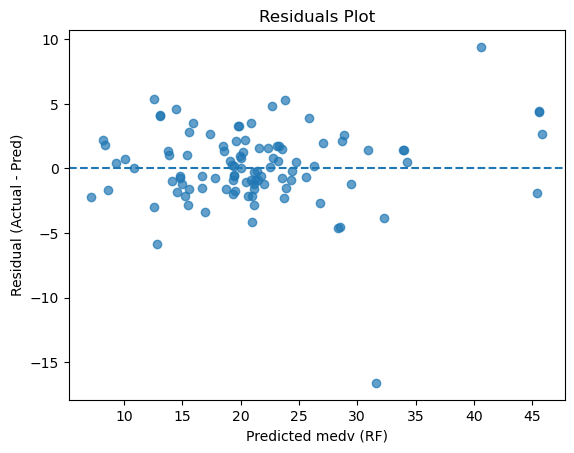

In [28]:
import matplotlib.pyplot as plt

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, pred_rf, alpha=0.7)
plt.xlabel("Actual medv")
plt.ylabel("Predicted medv (RF)")
plt.title("Predicted vs Actual")
# 45-degree reference line
xy = np.linspace(min(y_test.min(), pred_rf.min()), max(y_test.max(), pred_rf.max()))
plt.plot(xy, xy)
plt.show()

# Residuals
residuals = y_test - pred_rf
plt.figure()
plt.scatter(pred_rf, residuals, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted medv (RF)")
plt.ylabel("Residual (Actual - Pred)")
plt.title("Residuals Plot")
plt.savefig('residuals_plot.png')
plt.show()


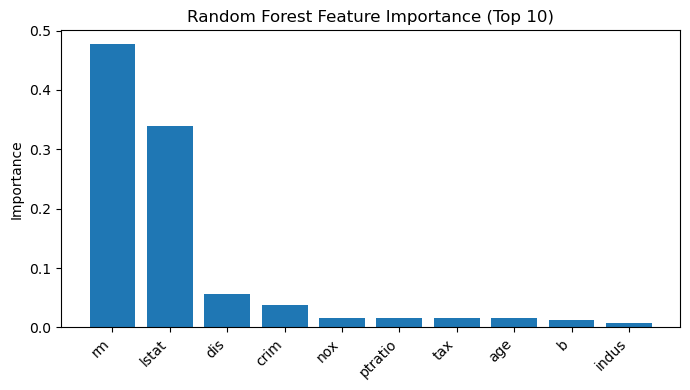

In [29]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
top_k = 10  # show top 10

plt.figure(figsize=(7,4))
plt.bar(range(top_k), importances[idx][:top_k])
plt.xticks(range(top_k), np.array(features)[idx][:top_k], rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance (Top 10)")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

print(
    "Ridge -> MAE: {:.2f}, RMSE: {:.2f}, R²: {:.3f}"
    .format(
        mean_absolute_error(y_test, pred_ridge),
        np.sqrt(mean_squared_error(y_test, pred_ridge)),
        r2_score(y_test, pred_ridge)
    )
)


Ridge -> MAE: 3.19, RMSE: 4.93, R²: 0.668


In [18]:
import joblib
joblib.dump(rf, "house_price_rf_model.joblib")
# Later: loaded_model = joblib.load("house_price_rf_model.joblib")


['house_price_rf_model.joblib']

In [20]:
import joblib

# Load the saved Random Forest model
loaded_model = joblib.load("house_price_rf_model.joblib")

# Now use it for predictions
preds = loaded_model.predict(X_test)
print(preds[:5])


[22.79825 30.9505  16.9755  23.50675 16.6735 ]


In [21]:
import joblib


In [22]:
# Load the saved Random Forest model
loaded_model = joblib.load("house_price_rf_model.joblib")


In [23]:
# Now use it for predictions
preds = loaded_model.predict(X_test)


In [24]:
print(preds[:5])


[22.79825 30.9505  16.9755  23.50675 16.6735 ]


In [25]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 2.9805383291643177
R² Score: 0.8788606240019529
